# VO2max Prediction Using Treadmill Maximal Exercise Tests and Machine Learning Techniques

In [37]:
# import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal
from collections import Counter
from sklearn.utils import indexable
from sklearn.utils import resample
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from itertools import chain
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, MultiTaskLassoCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import ceil, floor

In [38]:
# load subject dataset
subject_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/subject-info.csv')

# basic information
display(subject_data.head())
print("Initial Dataset Info:")
print(subject_data.info())
print(subject_data.describe())

,Age,Weight,Height,Humidity,Temperature,Sex,ID,ID_test
0,10.8,48.8,163.0,39.0,20.7,1,543,543_1
1,11.8,41.0,150.0,41.0,22.3,1,11,11_1
2,12.2,46.0,160.0,37.0,21.5,0,829,829_1
3,13.2,71.0,190.0,49.0,23.8,1,284,284_1
4,13.7,53.8,169.7,40.0,25.3,0,341,341_1


Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          992 non-null    float64
 1   Weight       992 non-null    float64
 2   Height       992 non-null    float64
 3   Humidity     962 non-null    float64
 4   Temperature  962 non-null    float64
 5   Sex          992 non-null    int64  
 6   ID           992 non-null    int64  
 7   ID_test      992 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 62.1+ KB
None
              Age      Weight      Height    Humidity  Temperature  \
count  992.000000  992.000000  992.000000  962.000000   962.000000   
mean    28.979133   73.383367  174.913508   48.211435    22.818565   
std     10.076653   12.005361    7.950027    8.560991     2.784066   
min     10.800000   41.000000  150.000000   23.700000    15.000000   
25%     21.100000   66.000000  170.0

In [39]:
# load measurement dataset
measurement_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/test_measure.csv')

# basic information
measurement_data

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID
0,0,5.0,63.0,478.0,360.0,27,13.3,2_1,2
1,2,5.0,75.0,401.0,295.0,23,10.3,2_1,2
2,4,5.0,82.0,449.0,319.0,29,12.2,2_1,2
3,7,5.0,87.0,461.0,340.0,28,12.8,2_1,2
4,9,5.0,92.0,574.0,417.0,28,14.6,2_1,2
...,...,...,...,...,...,...,...,...,...
575082,926,5.0,148.0,1350.0,1699.0,35,65.7,857_1,857
575083,927,5.0,147.0,1275.0,1605.0,32,60.1,857_1,857
575084,929,5.0,147.0,1259.0,1566.0,29,57.0,857_1,857
575085,931,5.0,147.0,1278.0,1587.0,31,58.5,857_1,857


In [40]:
# merge both datasets on ID
#merged_data = pd.merge(measurement_data, subject_data, on='ID', how='inner')
merged_data = measurement_data
merged_data

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID
0,0,5.0,63.0,478.0,360.0,27,13.3,2_1,2
1,2,5.0,75.0,401.0,295.0,23,10.3,2_1,2
2,4,5.0,82.0,449.0,319.0,29,12.2,2_1,2
3,7,5.0,87.0,461.0,340.0,28,12.8,2_1,2
4,9,5.0,92.0,574.0,417.0,28,14.6,2_1,2
...,...,...,...,...,...,...,...,...,...
575082,926,5.0,148.0,1350.0,1699.0,35,65.7,857_1,857
575083,927,5.0,147.0,1275.0,1605.0,32,60.1,857_1,857
575084,929,5.0,147.0,1259.0,1566.0,29,57.0,857_1,857
575085,931,5.0,147.0,1278.0,1587.0,31,58.5,857_1,857


## Feature Selection

The feature selection process is based on the Paper: ... .

### Data Cleaning and Pre-processing

In [41]:
# check if there are missing values
print(merged_data.isnull().sum())

time          0
Speed         0
HR          981
VO2        4871
VCO2       4871
RR            0
VE            0
ID_test       0
ID            0
dtype: int64


In [42]:
# remove rows with missing target variable (HR, VO2)
merged_data_cleaned = merged_data.dropna(subset=['HR', 'VO2'])

# Check how many rows are removed
print(f'Rows removed due to missing HR or VO2: {len(merged_data) - len(merged_data_cleaned)}')

Rows removed due to missing HR or VO2: 5840


In [58]:
# if all data from one specific test_ID has to be removed where missing values of HR or VO2 are present
difference = pd.merge(merged_data, merged_data_cleaned, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
exclude_ids = difference['ID_test'].unique()

merged_data_cleaned = merged_data_cleaned[~merged_data_cleaned['ID_test'].isin(exclude_ids)]

In [65]:
print("Exercise Data RR Intervals:")
merged_data_cleaned['RR']

Exercise Data RR Intervals:


602       30.0
603       29.0
604       29.0
605       32.0
606       34.0
          ... 
575082    35.0
575083    32.0
575084    29.0
575085    31.0
575086    31.0
Name: RR, Length: 381609, dtype: float64

In [64]:
# remove RR intervals exclusive to the range 300-2000 ms
# those are considered as outliers
# Entferne RR-Werte, die außerhalb des Bereichs von 5-50 Atemzügen pro Minute liegen (Ausreißer)
merged_data_cleaned['RR'] = np.where((merged_data_cleaned['RR'] < 5) | (merged_data_cleaned['RR'] > 50), np.nan, merged_data_cleaned['RR'])

# linear interpolation to fill missing values
merged_data_cleaned['RR'] = merged_data_cleaned['RR'].interpolate(method='linear')

# Check for NaN values after interpolation
merged_data_cleaned.isnull().sum()

time       0
Speed      0
HR         0
VO2        0
VCO2       0
RR         0
VE         0
ID_test    0
ID         0
dtype: int64

In [35]:
# remove data points where HR and VO2 are out of ohase
delta_hr = np.diff(merged_data_cleaned['HR'])
delta_vo2max = np.diff(merged_data_cleaned['VO2'])

merged_data_cleaned = merged_data_cleaned.iloc[:-1]  # Drop the last row
in_phase_mask = (delta_hr * delta_vo2max) > 0  # Create a mask for in-phase points
merged_data_cleaned = merged_data_cleaned[in_phase_mask]


In [ ]:
#  remove where consecutive HR differs more by than 30 bpm_
merged_data_cleaned['HR_diff'] = merged_data_cleaned['HR'].diff().abs()
merged_data_cleaned = merged_data_cleaned[merged_data_cleaned['HR_diff'] <= 30]

# remove objects with less than 5 minutes of data
merged_data_cleaned['time'] = merged_data_cleaned['time'].astype(float)  # make it numeirc
merged_data_cleaned = merged_data_cleaned[merged_data_cleaned['time'] >= 300]

# check dataset
print(f'Dataset size after cleaning: {merged_data_cleaned.shape}')

Dataset size after cleaning: (622931, 17)


In [150]:
# split data into exercise and recovery phases
exercise_data = merged_data_cleaned[merged_data_cleaned['Speed'] >= 5]  # Exercise phase
recovery_data = merged_data_cleaned[merged_data_cleaned['Speed'] < 5]  # Recovery phase

# shapes of dataframes
print(f'Exercise data size: {exercise_data.shape}')
print(f'Recovery data size: {recovery_data.shape}')

Exercise data size: (573861, 17)
Recovery data size: (49070, 17)


## Feature Extraction

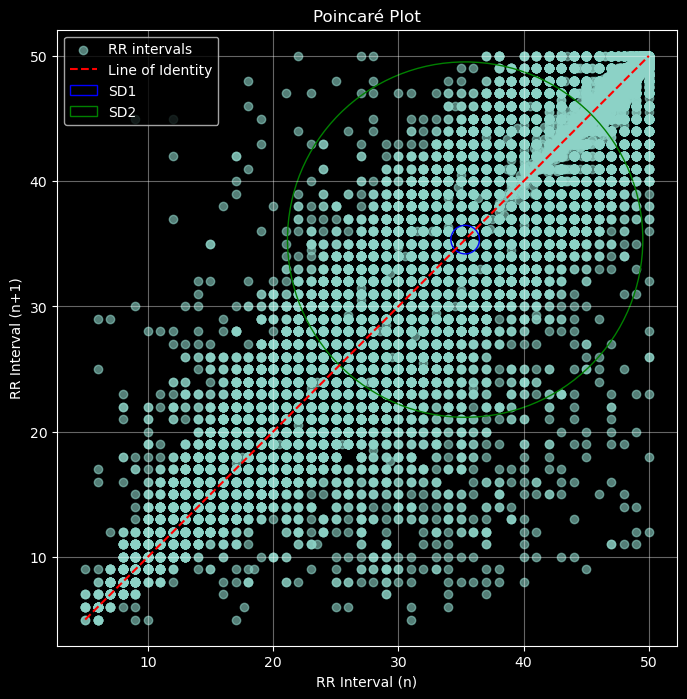

SD1: 1.14 ms
SD2: 14.19 ms


In [30]:
# Sample RR intervals (replace with your own data)
rr_intervals = merged_data_cleaned['RR'].values
# Calculate consecutive differences
rr_diff1 = rr_intervals[:-1]
rr_diff2 = rr_intervals[1:]

# Calculate mean of RR intervals
rr_mean = np.mean(rr_intervals)

# Calculate SD1 and SD2
sd1 = np.sqrt(0.5) * np.std(rr_diff2 - rr_diff1)
sd2 = np.sqrt(2 * np.std(rr_diff1)**2 - sd1**2)

# Line of identity
identity_line = np.linspace(min(rr_intervals), max(rr_intervals), 100)

# Create Poincaré plot
plt.figure(figsize=(8, 8))
plt.scatter(rr_diff1, rr_diff2, alpha=0.6, label="RR intervals")
plt.plot(identity_line, identity_line, color="red", linestyle="--", label="Line of Identity")
plt.xlim(min(rr_intervals), max(rr_intervals)+20)
plt.ylim(min(rr_intervals), max(rr_intervals)+20)
# SD1 and SD2 ellipse visualization
mean_rr = [np.mean(rr_diff1), np.mean(rr_diff2)]
ellipse_angle = 45
ellipse_sd1 = plt.Circle(mean_rr, sd1, color="blue", fill=False, label="SD1")
ellipse_sd2 = plt.Circle(mean_rr, sd2, color="green", fill=False, label="SD2")
plt.gca().add_patch(ellipse_sd1)
plt.gca().add_patch(ellipse_sd2)

# Formatting
plt.title("Poincaré Plot")
plt.xlabel("RR Interval (n)")
plt.ylabel("RR Interval (n+1)")
plt.legend()
plt.grid(alpha=0.4)
plt.axis("equal")
plt.show()

# Print SD1 and SD2
print(f"SD1: {sd1:.2f} ms")
print(f"SD2: {sd2:.2f} ms")


In [ ]:
# auch mit chat GPT lol
from scipy.signal import welch
from scipy.stats import linregress, shapiro

def calculate_slopes(df, feature):
    slope = linregress(df['time'], df[feature]).slope
    return slope

# all HR Features

def compute_hr_features(segment: pd.DataFrame) -> dict:

    hr = segment['HR'].values
    time = segment['time'].values
    rr_intervals = segment['RR'].values 

    # Zeit-Domain-Features
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))  # Berechnung von RMSSD
    pnn20 = np.mean(np.abs(np.diff(rr_intervals)) > 0.5) * 100  # Prozentsatz der Differenzen > 20 ms ~ 0.5 respiration/min
    pnn50 = np.mean(np.abs(np.diff(rr_intervals)) > 1.25) * 100  # Prozentsatz der Differenzen > 50 ms
    nni20 = np.sum(np.abs(np.diff(rr_intervals)) > 0.5)      # Anzahl der Differenzen > 20 ms
    nni50 = np.sum(np.abs(np.diff(rr_intervals)) > 1.25)      # Anzahl der Differenzen > 50 ms
    nni_range = np.max(rr_intervals) - np.min(rr_intervals)  # Bereich zwischen max. und min. RR-Intervall
    
    # Frequenz-Domain-Features
    
    # total_power = np.var(detrend(rr_intervals))  # Gesamtvarianz nach Detrend
    # vlf_power = total_power * 0.1  # Dummy-Verhältnis für VLF-Power (simuliert)
    # lf_power = total_power * 0.3  # Dummy-Verhältnis für LF-Power (simuliert)
    # hf_power = total_power * 0.6  # Dummy-Verhältnis für HF-Power (simuliert)
    
    fs = 4  # Annahme: Sampling-Frequenz von 4 Hz
    f, pxx = welch(rr_intervals, fs, nperseg=len(rr_intervals))
    vlf_power = np.trapz(pxx[(f >= 0.003) & (f < 0.04)], f[(f >= 0.003) & (f < 0.04)])
    lf_power = np.trapz(pxx[(f >= 0.04) & (f < 0.15)], f[(f >= 0.04) & (f < 0.15)])
    hf_power = np.trapz(pxx[(f >= 0.15) & (f < 0.4)], f[(f >= 0.15) & (f < 0.4)])
    lf_nu_power = lf_power / (vlf_power + lf_power + hf_power)

    # Nichtlineare Merkmale (Poincare Plot, DFA)
    sd1 = np.sqrt(0.5) * np.std(rr_diff2 - rr_diff1)
    sd2 = np.sqrt(2 * np.std(rr_diff1)**2 - sd1**2)
    
    # sd1 = np.std(rr_intervals[:len(rr_intervals)//2])  # Kurzfristige Variation (SD1)
    # sd2 = np.std(rr_intervals[len(rr_intervals)//2:])  # Langfristige Variation (SD2)

    # sd1 = np.std(hr[:len(hr)//2])
    # sd2 = np.std(hr[len(hr)//2:])
    
    # DFA (Detrended Fluctuation Analysis) als Platzhalter (echte Implementierung erfordert spezialisierte Bibliotheken)
    # Dummy-Wert für DFA a1 (z.B. von einer DFA-Analyse)
    #dfa_a1 = 0.75  # Beispielwert für DFA a1
    dfa_a1 = np.std(rr_intervals[:len(rr_intervals)//2]) / np.std(rr_intervals) # placeholder
    

    # Berechnung der Steigungen der Merkmale über die Zeit
    # Beispiel: Steigung des HRs über Zeit
    #slope_nni = np.polyfit(time, hr, 1)[0]
    
    # # Da vlf_power, lf_power und hf_power konstante Werte sind, berechnen wir ihre Steigung nicht
    # slope_vlf = np.nan
    # slope_lf = np.nan
    # slope_hf = np.nan
    
    # # Steigungen für Poincare Plot-Merkmale
    # slope_sd1 = np.polyfit(time, [sd1] * len(time), 1)[0]
    # slope_sd2 = np.polyfit(time, [sd2] * len(time), 1)[0]

    # Zeitbasierte Merkmale (Beispiel)
    max_speed = segment['Speed'].max()
    max_hr = max(segment['HR'])
    min_hr = min(segment['HR'])
    # slope_sp25 = calculate_slopes(segment[segment['Speed'] <= max_speed * 0.25], 'HR')
    # slope_sp50 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.5) & (segment['Speed'] > max_speed * 0.25)], 'HR')
    # slope_sp75 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.75) & (segment['Speed'] > max_speed * 0.5)], 'HR')
    # slope_sp100 = calculate_slopes(segment[(segment['Speed'] > max_speed * 0.75)], 'HR')
    rt25 = segment.loc[segment['time'] <= segment['time'].max() * 0.25, 'HR'].corr(segment['time'])
    rt50 = segment.loc[(segment['time'] <= segment['time'].max() * 0.25) & (segment['time'] < segment['time'].max() * 0.5), 'HR'].corr(segment['time'])
    rt75 = segment.loc[(segment['time'] <= segment['time'].max() * 0.5) & (segment['time'] < segment['time'].max() * 0.75), 'HR'].corr(segment['time'])
    rsp75 = segment.loc[segment['Speed'] <= max_speed * 0.75, 'HR'].corr(segment['Speed'])
    rsp25 = segment.loc[segment['Speed'] <= max_speed * 0.25, 'HR'].corr(segment['Speed'])
    time_sp25 = segment[segment['Speed'] >= max_speed * 0.25]['time'].min()
    time_hr25 = segment[segment['HR'] >= max_hr * 0.25]['time'].min()
    time_hr50 = segment[segment['HR'] >= max_hr * 0.5]['time'].min()
    time_hr75 = segment[segment['HR'] >= max_hr * 0.75]['time'].min()
    duration_hr60 = len(segment[(segment['HR'] >= max_hr * 0.5) & (segment['HR'] < max_hr * 0.6)]) * (segment['time'].diff().mean())
    duration_hr70 = len(segment[(segment['HR'] >= max_hr * 0.6) & (segment['HR'] < max_hr * 0.7)]) * (segment['time'].diff().mean())
    duration_hr80 = len(segment[(segment['HR'] >= max_hr * 0.7) & (segment['HR'] < max_hr * 0.8)]) * (segment['time'].diff().mean())
    duration_hr90 = len(segment[(segment['HR'] >= max_hr * 0.8) & (segment['HR'] < max_hr * 0.9)]) * (segment['time'].diff().mean())
    duration_hr100 = len(segment[(segment['HR'] >= max_hr * 0.9) & (segment['HR'] <= max_hr)]) * (segment['time'].diff().mean())

    
    # Feature Dictionary
    Features = {'RMSSD': rmssd,
        'PNN20': pnn20,
        'PNN50': pnn50,
        'NNI20': nni20,
        'NNI50': nni50,
        'NNI_Range': nni_range,
        'VLF_Power': vlf_power,
        'LF_Power': lf_power,
        'HF_Power': hf_power,
        'LF_Nu_Power': lf_nu_power,
        'SD1': sd1,
        'SD2': sd2,
        'DFA_A1': dfa_a1,
        #'Slope_NNI': slope_nni,
        # 'Slope_Speed25': slope_sp25,
        # 'Slope_Speed50': slope_sp50,
        # 'Slope_Speed75': slope_sp75,
        # 'Slope_Speed100': slope_sp100,
        'RT25': rt25,
        'RT50': rt50,
        'RT75': rt75,
        'RSP75': rsp75,
        'RSP25': rsp25,
        'Time_SP25': time_sp25,
        'Time_HR25': time_hr25,
        'Time_HR50': time_hr50,
        'Time_HR75': time_hr75,
        'DurationHR60': duration_hr60,
        'DurationHR70': duration_hr70,
        'DurationHR80': duration_hr80,
        'DurationHR90': duration_hr90,
        'DurationHR100': duration_hr100
    }
    
    return Features
    



In [131]:
def calculate_features_per_segment(df, test_column):
    """
    Berechnet Features für jedes Segment basierend auf der test_ID.
    
    Parameters:
    df (pd.DataFrame): Der DataFrame, der die Daten enthält.
    test_column (str): Der Name der Spalte, die die Test-IDs enthält.
    
    Returns:
    pd.DataFrame: Ein DataFrame mit den berechneten Features für jedes Segment.
    """
    # Leere Liste für die Features pro Segment
    all_features = []

    # Gehe durch jede Gruppe (Segment) basierend auf der test_ID
    for test_id, df_segment in df.groupby(test_column):
        # Berechne die Features für das aktuelle Segment
        features = compute_hr_features(df_segment)
        # Füge die Test-ID zu den Features hinzu
        features[test_column] = test_id
        # Hänge die Features für dieses Segment an die Liste an
        all_features.append(features)

    # Erstelle einen DataFrame aus der Liste der Features
    #df_features = pd.DataFrame(all_features)
    
    return all_features

#new_features = calculate_features_per_segment(merged_data_cleaned, 'ID_test_y')

In [132]:
for test_id, df_segment in merged_data_cleaned.groupby('ID_test'):
    #print(test_id)
    if test_id == '3_1':
        test_segment = merged_data_cleaned[merged_data_cleaned['ID_test'] == test_id]
        break
compute_hr_features(test_segment)

[1.         0.         3.         2.         1.         1.
 5.         1.         2.         0.         1.         0.
 0.         1.         1.         2.         5.         3.
 1.         2.         0.         1.         0.         2.
 0.         1.         4.         5.         4.         3.
 0.         2.         0.         2.         0.         4.
 0.         0.         0.         0.         1.         1.
 0.         0.         1.         1.         2.         1.
 0.         1.         1.         0.         1.         2.
 0.         1.         0.         1.         2.         3.
 3.         0.         0.         0.         1.         3.
 4.         0.         1.         2.         1.         1.
 2.         1.         1.         2.         3.         2.
 3.         2.         2.         0.         0.         0.
 2.         2.         2.         1.         1.         2.
 1.         2.         0.         2.         2.         1.
 2.         0.         1.         0.         2.         

{'RMSSD': 1.6488039627872175,
 'PNN20': 51.98675496688742,
 'PNN50': 26.490066225165563,
 'NNI20': 314,
 'NNI50': 160,
 'NNI_Range': 29.0,
 'VLF_Power': 33.458290814947134,
 'LF_Power': 8.350130001077444,
 'HF_Power': 2.8005995899076574,
 'LF_Nu_Power': 0.18718478740606956,
 'SD1': 1.1406732152560382,
 'SD2': 14.185146916503193,
 'DFA_A1': 0.7274862310752898,
 'RT25': 0.9647716602241477,
 'RT50': 0.9647716602241477,
 'RT75': 0.9902707860198263,
 'RSP75': 0.3066285553414507,
 'RSP25': nan,
 'Time_SP25': 0,
 'Time_HR25': 0,
 'Time_HR50': 13,
 'Time_HR75': 280,
 'DurationHR60': 77.32450331125827,
 'DurationHR70': 96.65562913907284,
 'DurationHR80': 198.14403973509934,
 'DurationHR90': 209.4205298013245,
 'DurationHR100': 383.4006622516556}

In [179]:
new_features = pd.DataFrame(new_features)
new_features['ID_test'] = new_features['ID_test_y']
new_features

,RMSSD,PNN20,PNN50,NNI20,NNI50,NNI_Range,VLF_Power,LF_Power,HF_Power,LF_Nu_Power,...,Time_HR25,Time_HR50,Time_HR75,DurationHR60,DurationHR70,DurationHR80,DurationHR90,DurationHR100,ID_test_y,ID_test
0,1.481071,0.0,0.0,0,0,24.0,7.277623,4.303086,2.771932,0.299811,...,301.0,301.0,361.0,23.796499,80.908096,103.118162,174.507659,341.083151,100_1,100_1
1,1.153176,0.0,0.0,0,0,27.0,13.721111,2.372173,0.633813,0.141816,...,300.0,300.0,306.0,0.000000,0.000000,110.796834,338.121372,276.992084,101_1,101_1
2,0.973329,0.0,0.0,0,0,31.0,23.083816,1.677281,1.060094,0.064958,...,300.0,300.0,300.0,0.000000,0.000000,84.000000,164.000000,324.000000,102_1,102_1
3,1.505314,0.0,0.0,0,0,20.0,8.501543,0.682572,0.598572,0.069774,...,300.0,300.0,300.0,0.000000,49.621622,51.000000,188.837838,272.918919,103_1,103_1
4,1.300821,0.0,0.0,0,0,29.0,10.853108,1.639056,1.747539,0.115105,...,301.0,301.0,303.0,0.000000,56.831461,155.339326,339.094382,293.629213,104_1,104_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,1.757981,0.0,0.0,0,0,32.0,58.450279,1.908188,1.116328,0.031040,...,301.0,301.0,490.0,18.407240,243.384615,169.755656,145.212670,329.285068,98_1,98_1
977,1.122955,0.0,0.0,0,0,33.0,49.346644,3.473053,2.165212,0.063164,...,300.0,300.0,300.0,25.696721,66.811475,102.215847,255.825137,177.021858,99_1,99_1
978,1.122946,0.0,0.0,0,0,33.0,49.341144,3.472413,2.164424,0.063160,...,300.0,300.0,300.0,25.696721,66.811475,102.215847,255.825137,177.021858,99_47,99_47
979,1.122955,0.0,0.0,0,0,33.0,49.335655,3.471803,2.163677,0.063157,...,300.0,300.0,300.0,25.696721,66.811475,102.215847,255.825137,177.021858,99_54,99_54


In [7]:
#merged_data = pd.merge(subject_data, new_features, on='ID_test', how='inner')
#merged_data
# save the merged data
#merged_data.to_csv('merged_data.csv')